In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import pandas as pd
import numpy as np
from torch.nn import functional as F
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import r2_score

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


#### Load the data

In [6]:
X_static = np.load("data/preprocessed/static_data.npy")
X_dynamic = np.load("data/preprocessed/dynamic_data.npy")

In [7]:
print(f"The shape of the listing information is {X_static.shape}, and price information is {X_dynamic.shape}")

The shape of the listing information is (2628, 54), and price information is (2628, 279)


#### Scale the dataset



In [8]:
static_scaler = RobustScaler()
X_static = static_scaler.fit_transform(X_static)
dynamic_scaler = RobustScaler()
X_dynamic = dynamic_scaler.fit_transform(X_dynamic)

#### Consider only those sample in which there is a change in the values

In [9]:
def is_static(sample, threshold=0.1):
    return np.std(sample) > threshold

#### Consider k input time series instead of the entire 279 series. Slice accordingly

In [10]:
# Since y is the last price to be predicted
k = 10
X_dynamic_prime = []
y_dynamic_prime = []
X_static_prime = []
for i in range(len(X_dynamic)):
  #print(i)
  for j in range(X_dynamic.shape[1]-(k+1)):
    #print(j)
    X_dynamic_prime.append(X_dynamic[i,j:j+k])
    y_dynamic_prime.append(X_dynamic[i, j+k+1])
    X_static_prime.append(X_static[i])
X_static_prime, X_dynamic_prime, y = np.array(X_static_prime), np.array(X_dynamic_prime), np.array(y_dynamic_prime)

In [11]:
fluctuating_indices = [i for i, sample in enumerate(X_dynamic_prime) if is_static(sample)]
print(len(fluctuating_indices))
X_dynamic = X_dynamic_prime[fluctuating_indices]
X_static = X_static_prime[fluctuating_indices]
y = y[fluctuating_indices]

28276


In [12]:
print(X_static.shape, X_dynamic.shape)

(28276, 54) (28276, 10)


#### Consider 278 input time series and 1 output time series

In [13]:
# # # Since y is the last price to be predicted
# y = X_dynamic[:, -1]
# X_dynamic = X_dynamic[:, :-1]
# print(y.shape)

#### Do train, test split using indices

In [14]:
def return_indices(num_samples, split_ratio = (0.7, 0.15, 0.15)):
  # Define the ratios for train, validation, and test sets
  train_ratio, val_ratio, test_ratio = split_ratio


  # Calculate the size of each set
  train_size = int(train_ratio * num_samples)
  val_size = int(val_ratio * num_samples)
  test_size = num_samples - train_size - val_size

  # Generate the list of indices
  indices = list(range(num_samples))

  # Shuffle the indices randomly
  np.random.shuffle(indices)

  # Split the shuffled indices into train, validation, and test sets
  train_ids = indices[:train_size]
  val_ids = indices[train_size:train_size + val_size]
  test_ids = indices[train_size + val_size:]
  return (train_ids, val_ids, test_ids)

In [15]:
num_samples = X_dynamic.shape[0]
train_ids, val_ids, test_ids = return_indices(num_samples)
print(f"Number of training, validation, and test samples are: {len(train_ids)}, {len(val_ids)}, and {len(test_ids)}")

Number of training, validation, and test samples are: 19793, 4241, and 4242


In [16]:
X_static_train, X_static_val, X_static_test = X_static[train_ids], X_static[val_ids], X_static[test_ids]
X_dynamic_train, X_dynamic_val, X_dynamic_test = X_dynamic[train_ids], X_dynamic[val_ids], X_dynamic[test_ids]
y_train, y_val, y_test = y[train_ids], y[val_ids], y[test_ids]

In [17]:
print(f"Shape of static train, val and test are: {X_static_train.shape}, {X_static_val.shape}, and {X_static_test.shape}")
print(f"Shape of dynamic train, val and test are: {X_dynamic_train.shape}, {X_dynamic_val.shape}, and {X_dynamic_test.shape}")
print(f"Shape of y train, val and test are: {y_train.shape}, {y_val.shape}, and {y_test.shape}")

Shape of static train, val and test are: (19793, 54), (4241, 54), and (4242, 54)
Shape of dynamic train, val and test are: (19793, 10), (4241, 10), and (4242, 10)
Shape of y train, val and test are: (19793,), (4241,), and (4242,)


#### Define model architecture

In [18]:
class AirbnbLSTM(nn.Module):
    def __init__(self, static_feature_dim, embedding_dim, lstm_input_dim, lstm_hidden_dim, lstm_output_dim, dropout = 0.1):
        super(AirbnbLSTM, self).__init__()

        self.static_feature_dim = static_feature_dim
        self.embedding_dim = embedding_dim
        self.lstm_input_dim = lstm_input_dim
        self.lstm_hidden_dim = lstm_hidden_dim
        self.lstm_output_dim = lstm_output_dim
        self.dropout_value = dropout


        # Embedding network for static features
        self.embedding_network = nn.Sequential(
            nn.Linear(self.static_feature_dim, 32),  # Adjust hidden layer size as needed
            nn.ReLU(),
            nn.Dropout(p=self.dropout_value),
            nn.Linear(32, self.embedding_dim)
        )

        # LSTM network
        self.lstm = nn.LSTM(self.lstm_input_dim + self.embedding_dim, self.lstm_hidden_dim, batch_first=True)

        # Output layer
        self.output_layer = nn.Linear(self.lstm_hidden_dim, self.lstm_output_dim)

    def forward(self, static_features, price_sequence):
      static_features = static_features.float()
      price_sequence = price_sequence.float()

      # Embed static features
      embedded_features = self.embedding_network(static_features) # (batch, embed_dim)

      # Repeat embedded features for each time step in the price sequence
      embedded_features_expanded = embedded_features.unsqueeze(1).expand(-1, price_sequence.size(1), -1) # (batch, time, embed_dim)

      # Concatenate embedded features with price sequence
      lstm_input = torch.cat([embedded_features_expanded, price_sequence], dim=2) # (batch, time, embed_dim + lstm_input_dim)

      #print(lstm_input.size())

      # Initialize hidden state and cell state
      h_0 = torch.zeros(1, lstm_input.size(0), self.lstm_hidden_dim).to(lstm_input.device) # (num_layers, batch, hidden_size)
      c_0 = torch.zeros(1, lstm_input.size(0), self.lstm_hidden_dim).to(lstm_input.device) # (num_layers, batch, hidden_size)

      #print(h_0.size())

      # Forward pass through LSTM
      lstm_output, (hidden_state, cell_state) = self.lstm(lstm_input, (h_0, c_0)) # lstm_output: (batch, time, hidden_size)

      # Take the last time step's hidden state for prediction
      final_hidden_state = hidden_state[-1] # (batch, hidden_size)
      final_hidden_state = nn.Dropout(p=self.dropout_value)(final_hidden_state)


      # Prediction from final hidden state
      prediction = self.output_layer(final_hidden_state) # (batch, output_dim)
      return prediction

#### Instantiate the model

In [19]:
# # Define model parameters (replace with your desired values)
static_feature_dim = X_static_train.shape[1]  # Adjust based on your static features
embedding_dim = 8  # Dimensionality of the embedding vector
lstm_input_dim = 1  # Assuming price is the only dynamic feature
lstm_hidden_dim = 16  # Number of hidden units in the LSTM
lstm_output_dim = 1  # Predicting single value (e.g., price)
model = AirbnbLSTM(static_feature_dim, embedding_dim, lstm_input_dim, lstm_hidden_dim, lstm_output_dim)
model.cuda()

AirbnbLSTM(
  (embedding_network): Sequential(
    (0): Linear(in_features=54, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=32, out_features=8, bias=True)
  )
  (lstm): LSTM(9, 16, batch_first=True)
  (output_layer): Linear(in_features=16, out_features=1, bias=True)
)

#### Train and validate the model

In [20]:
train_dataset = TensorDataset(torch.tensor(X_static_train), torch.tensor(X_dynamic_train).unsqueeze(2), torch.tensor(y_train))
val_dataset = TensorDataset(torch.tensor(X_static_val), torch.tensor(X_dynamic_val).unsqueeze(2), torch.tensor(y_val))
test_dataset = TensorDataset(torch.tensor(X_static_test), torch.tensor(X_dynamic_test).unsqueeze(2), torch.tensor(y_test))

In [21]:
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle = False)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = 32, shuffle = False)
# next(iter(train_loader))[1].shape

In [22]:
# Sample training loop (replace with your actual data loaders and loss function)
num_epochs = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

training_loss = []
validation_loss = []

for epoch in range(num_epochs):

  if epoch%10 == 0:
    print(f"Running epoch: {epoch}")

  model.train()
  running_loss = 0
  for idx, batch in enumerate(train_loader):

    static_features = batch[0].to(device) # (batch, static_feature)
    price_sequence = batch[1].to(device) # (batch, time, dynamic_feature )

    final_price = batch[2].float().to(device) # (batch, )

    prediction = model(static_features, price_sequence)

    final_price = final_price.unsqueeze(1)
    # Calculate loss based on your desired objective (e.g., MSE)
    loss = F.mse_loss(prediction, final_price)
    running_loss += loss.item()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  training_loss.append(running_loss/len(train_loader))

  #print("Starting evaluation ....... ")
  model.eval()

  val_running_loss = 0
  for idx, batch in enumerate(val_loader):
    static_features = batch[0].to(device) # (batch, static_feature)
    price_sequence = batch[1].to(device) # (batch, time, dynamic_feature )

    final_price = batch[2].float().to(device) # (batch, )

    prediction = model(static_features, price_sequence)

    final_price = final_price.unsqueeze(1)

    # Calculate loss based on your desired objective (e.g., MSE)
    loss = F.mse_loss(prediction, final_price)
    val_running_loss += loss.item()
  validation_loss.append(val_running_loss / len(val_loader))


c:\Conda\envs\graph_NN\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running epoch: 0
Running epoch: 10
Running epoch: 20
Running epoch: 30
Running epoch: 40
Running epoch: 50
Running epoch: 60
Running epoch: 70
Running epoch: 80
Running epoch: 90


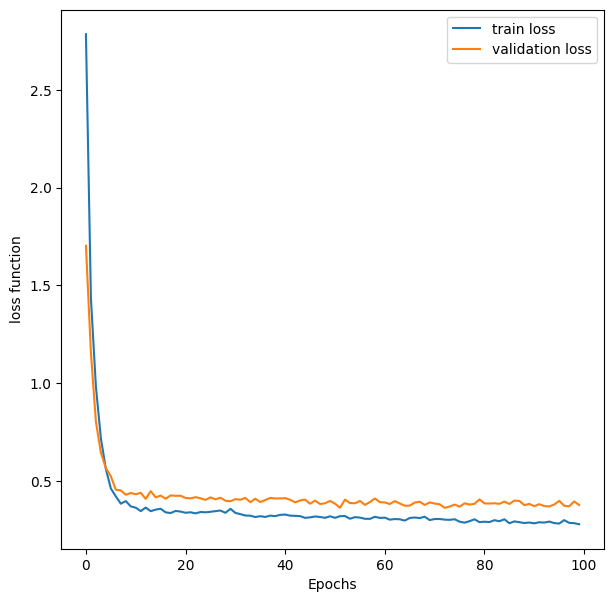

In [23]:
plt.figure(figsize = (7,7))
plt.xlabel("Epochs")
plt.ylabel("loss function")
plt.plot(training_loss, label = "train loss")
plt.plot(validation_loss, label = "validation loss")
plt.legend()
plt.show()

In [24]:
model.eval()
test_loss = 0
true_price = []
predicted_price = []
for idx, batch in enumerate(val_loader):
  static_features = batch[0].to(device) # (batch, static_feature)
  price_sequence = batch[1].to(device) # (batch, time, dynamic_feature )

  final_price = batch[2].float().to(device) # (batch, )

  prediction = model(static_features, price_sequence)

  final_price = final_price.unsqueeze(1)

  true_price.extend(final_price.cpu().numpy())
  predicted_price.extend(prediction.detach().cpu().numpy())

  # Calculate loss based on your desired objective (e.g., MSE)
  loss = F.mse_loss(prediction, final_price)
  test_loss += loss.item()


In [25]:
true_price = [float(price) for price in true_price]

# Convert each element in predicted_price list to integer
predicted_price = [float(price) for price in predicted_price]

C:\Users\Primakov Chungkham\AppData\Local\Temp\ipykernel_29228\3889970112.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  true_price = [float(price) for price in true_price]
C:\Users\Primakov Chungkham\AppData\Local\Temp\ipykernel_29228\3889970112.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  predicted_price = [float(price) for price in predicted_price]


In [26]:
r2_score(np.array(true_price), np.array(predicted_price))

0.9239599268224548